In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [2]:
# Install required libraries (if not already installed)
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import glob

# Load and Combine Train Parquet Partitions
# train_files = glob.glob("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/*/*.parquet")
# df_list = [pd.read_parquet(file) for file in train_files]
# train_df = pd.concat(df_list, ignore_index=True)
# print("Combined Train Data Shape:", train_df.shape)

In [4]:
import pandas as pd

# Specify paths to only two of the partition files
train_file_1 = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet"
train_file_2 = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet"

# Load only these two files
train_df_1 = pd.read_parquet(train_file_1)
train_df_2 = pd.read_parquet(train_file_2)

# Concatenate the two DataFrames
train_df = pd.concat([train_df_1, train_df_2], ignore_index=True)

print("Optimized Combined Train Data Shape:", train_df.shape)

Optimized Combined Train Data Shape: (4748457, 92)


In [5]:
train_df.columns

Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
       'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
       'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
       'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26',
       'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
       'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
       'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
       'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
       'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_6

In [6]:
# 1. Initial Data Inspection
print("Data Shape:", train_df.shape)
print("Data Columns:", train_df.columns)
print(train_df.info())
print(train_df.head())

Data Shape: (4748457, 92)
Data Columns: Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
       'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
       'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
       'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26',
       'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
       'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
       'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
       'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
       'feature_57', 'feature_58'

In [7]:
# 2. Check for Missing Values
missing_values = train_df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values[missing_values > 0])

# 3. Basic Statistical Summaries
print("Statistical Summary:\n", train_df.describe())


Missing Values in Each Column:
 feature_00    3182052
feature_01    3182052
feature_02    3182052
feature_03    3182052
feature_04    3182052
feature_08      16980
feature_15     134281
feature_16        104
feature_17      22499
feature_18         88
feature_19         88
feature_21    4748457
feature_26    4748457
feature_27    4748457
feature_31    4748457
feature_32      53192
feature_33      53192
feature_39     757287
feature_40      53167
feature_41     199569
feature_42     757287
feature_43      53167
feature_44     199569
feature_45     256434
feature_46     256434
feature_47         87
feature_50     715904
feature_51       5593
feature_52     156604
feature_53     715904
feature_54       5593
feature_55     156604
feature_56         88
feature_57         88
feature_58      53187
feature_62     235823
feature_63     196433
feature_64     202476
feature_65     256434
feature_66     256434
feature_73      53187
feature_74      53187
feature_75         62
feature_76         62


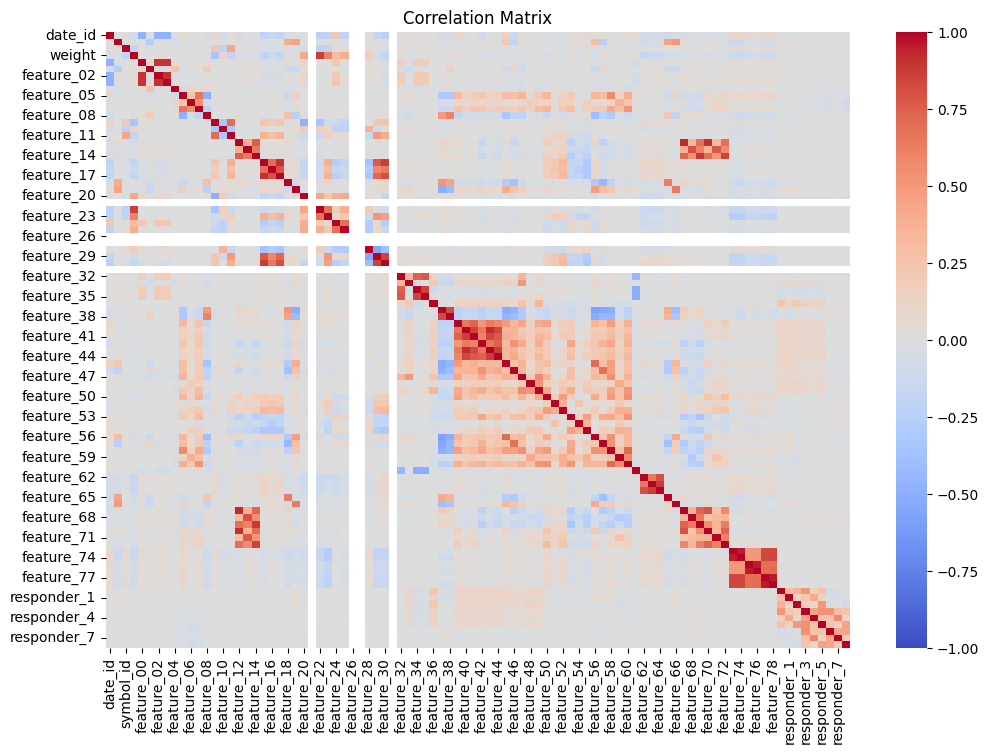

In [8]:
# 4. Correlation Analysis
correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Key Observations from the Correlation Matrix:

The correlation matrix highlights relationships between different features.

Strong correlations (deep red) suggest highly dependent variables, while strong negative correlations (deep blue) indicate inverse relationships.

The responder variables show some correlations with other features, which may be useful for predictive modeling.

Some feature blocks exhibit strong internal correlations, possibly indicating multi-collinearity.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


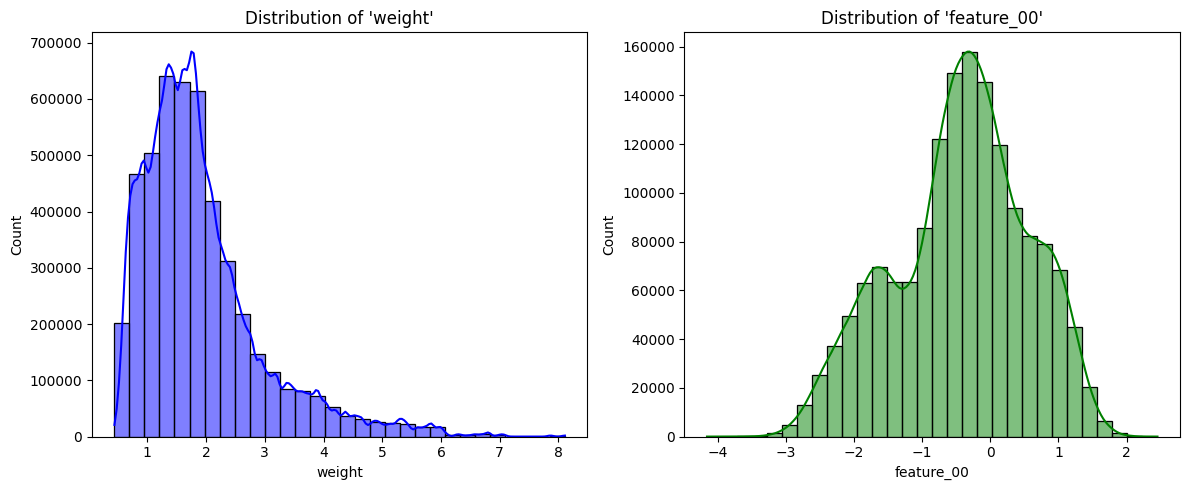

In [9]:
# 5. Distribution of `weight` and `feature_00`
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['weight'], kde=True, color='blue', bins=30)
plt.title("Distribution of 'weight'")
plt.subplot(1, 2, 2)
sns.histplot(train_df['feature_00'], kde=True, color='green', bins=30)
plt.title("Distribution of 'feature_00'")
plt.tight_layout()
plt.show()

Weight distribution : 

The weight variable is right-skewed, with most values between 1 and 3.

There are some outliers extending up to 7–8, which might require handling during preprocessing.

Feature_00_Distribution:

This feature follows a roughly normal distribution, centered around 0.

There are slight deviations and skewness in the tails.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

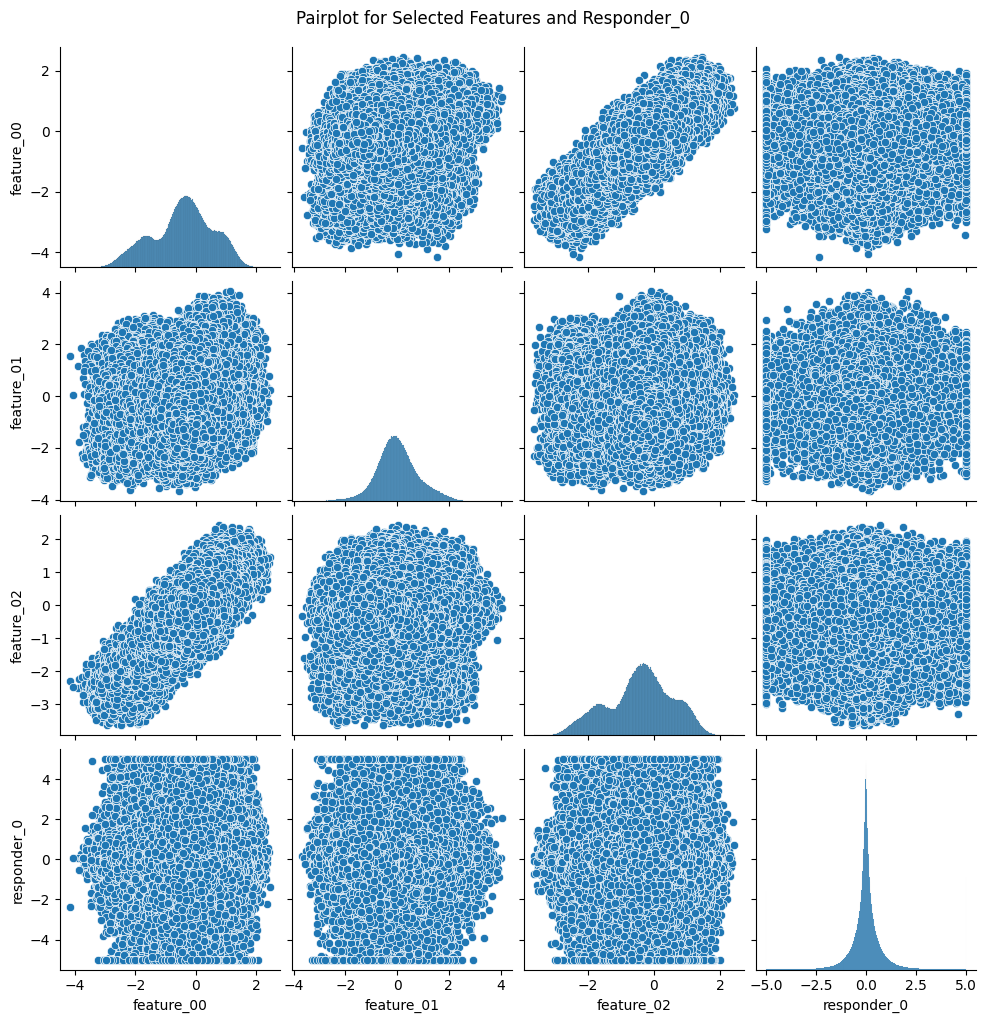

In [10]:
# 6. Exploring Relationship between Selected Features and Responders
sns.pairplot(train_df[['feature_00', 'feature_01', 'feature_02', 'responder_0']])
plt.suptitle("Pairplot for Selected Features and Responder_0", y=1.02)
plt.show()

Observations:

feature_00, feature_01, and feature_02 are approximately normally distributed.

feature_00 and feature_02 show a positive correlation.

responder_0 appears uniformly distributed without strong correlation to the selected features.

In [11]:
import pandas as pd

# Load the responder and feature CSVs
features_df = pd.read_csv("/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv")
responders_df = pd.read_csv("/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv")

# Verify column names before merging
print("Columns in train_df:", train_df.columns)
print("Columns in responders_df:", responders_df.columns)
print("Columns in features_df:", features_df.columns)

# Merge Responders and Features with Train Data
# Adjust column names if necessary based on the print statements
try:
    train_df = train_df.merge(responders_df, on='date_id', how='left')
    train_df = train_df.merge(features_df, on='feature_id', how='left')
    print("Merged Data Shape:", train_df.shape)
except KeyError as e:
    print(f"Column not found during merge: {e}")

Columns in train_df: Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
       'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
       'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
       'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26',
       'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
       'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
       'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
       'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
       'feature_57', 'feature_58', 'feature_59', 'fe

Dataset Columns: Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
       'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
       'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
       'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26',
       'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
       'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
       'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
       'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
       'feature_57', 'feature_58', 'feature_59', 'featur

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


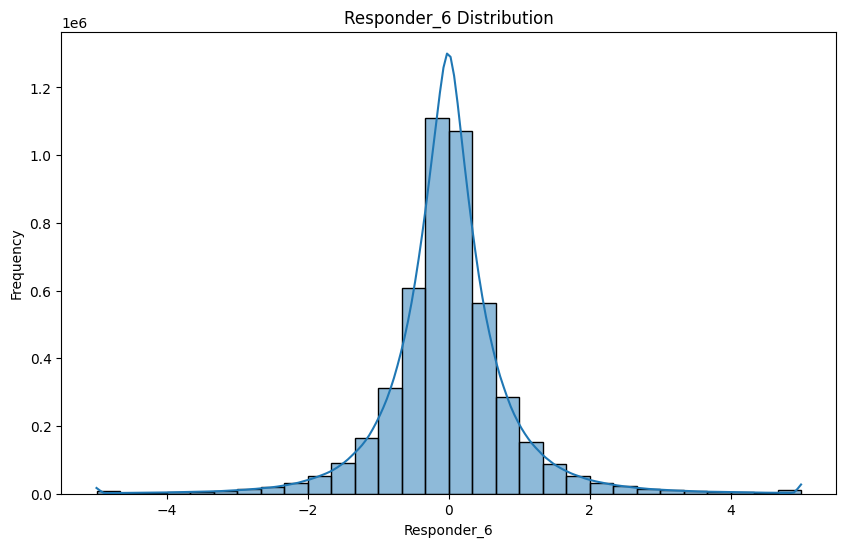

In [12]:
# Initial Exploration
print("Dataset Columns:", train_df.columns)
print("Dataset Types:\n", train_df.dtypes)
print("Missing Values:\n", train_df.isnull().sum())

# Target Variable Distribution (Responder_6)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['responder_6'], kde=True, bins=30)
plt.title('Responder_6 Distribution')
plt.xlabel('Responder_6')
plt.ylabel('Frequency')
plt.show()

Key Observations:

The distribution follows a normal-like pattern, centered around zero, with most values concentrated near the mean.

The symmetric shape suggests that Responder_6 does not have strong skewness.

The KDE overlay reinforces the assumption of a Gaussian distribution, which is useful for statistical modeling.

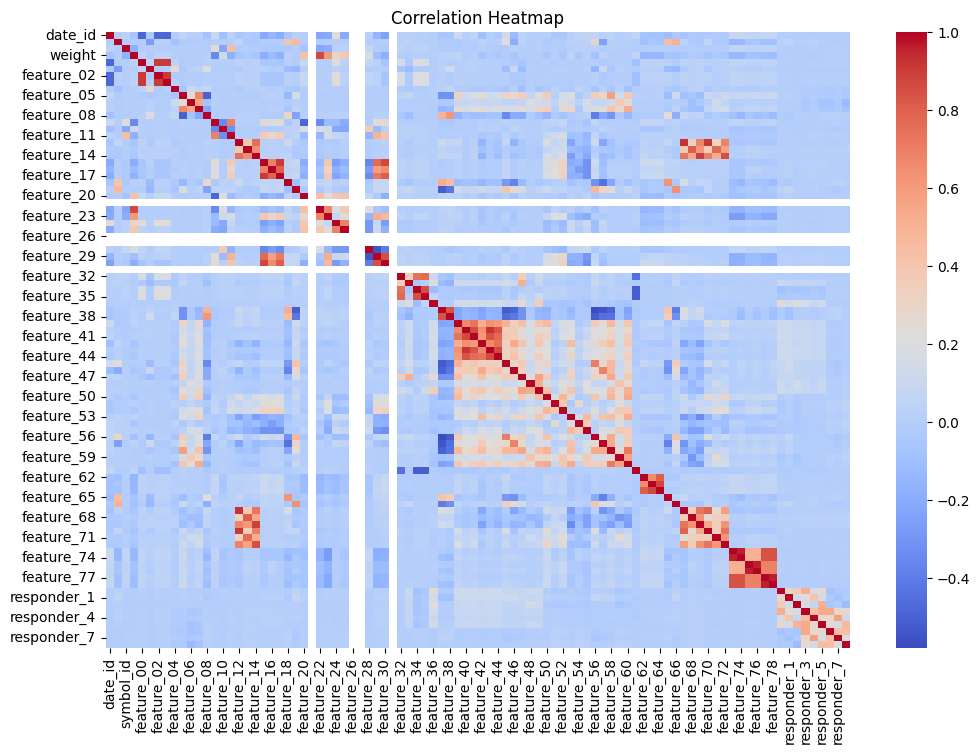

In [13]:
# Correlation Analysis
corr_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# Feature Selection by Correlation
correlation_target = corr_matrix['responder_6'].sort_values(ascending=False)
top_features = correlation_target.index[1:11]  # Top 10 correlated features, excluding responder_6 itself
print("Top Correlated Features with responder_6:\n", correlation_target.head(10))

Top Correlated Features with responder_6:
 responder_6    1.000000
responder_3    0.542425
responder_8    0.441470
responder_7    0.434857
responder_4    0.268392
responder_5    0.248837
feature_51     0.028686
feature_59     0.021348
feature_54     0.021329
feature_68     0.020753
Name: responder_6, dtype: float64


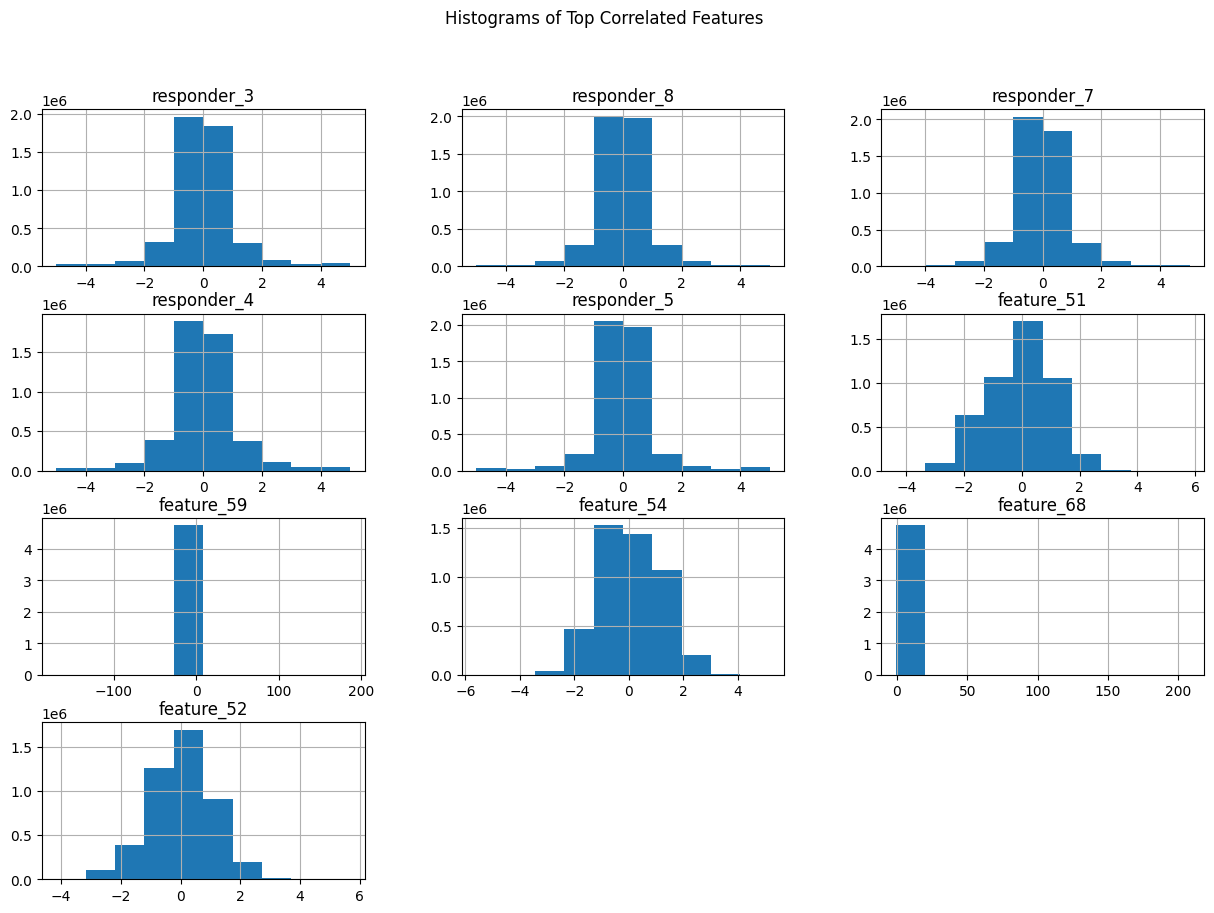

In [15]:
# Feature Distributions
train_df[top_features].hist(figsize=(15, 10))
plt.suptitle("Histograms of Top Correlated Features")
plt.show()

Observations:

Most features exhibit a normal distribution, centered around zero.

Some features, like feature_59 and feature_68, show distinct patterns that may require further investigation.

Understanding these distributions can help in feature engineering and model optimization.